In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/CDV/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [139]:
from tools.misc_tools import RK4_integrator

In [7]:
def central_dif(data, delta_x, der=None):
    '''
    central difference x-derivative of `data`, assuming
    `data` is periodic and on an equally spaced grid with
    grid spacing `delta_x`
    '''
    if der is None:
        der = np.empty_like(data)
    der[1:-1] = data[2:] - data[0:-2]
    der[0] = data[1] - data[-1]
    der[-1] = data[0] - data[-2]
    der /= 2*delta_x
    return der

In [75]:
def KS_time_der(data, delta_x, x_grid, mu=0.0, lmda=1.0, tder=None, xder=None, xxder=None, xxxder=None, xxxxder=None):
    if tder is None:
        tder = np.empty_like(data)
    if xder is None:
        xder = np.empty_like(data)
    if xxder is None:
        xxder = np.empty_like(data)
    if xxxder is None:
        xxxder = np.empty_like(data)
    if xxxxder is None:
        xxxxder = np.empty_like(data)

    xder = central_dif(data, delta_x, der=xder)
    xxder = central_dif(xder, delta_x, der=xxder)
    xxxder = central_dif(xxder, delta_x, der=xxxder)
    xxxxder = central_dif(xxxder, delta_x, der=xxxxder)
    x2der = 0.5*central_dif(data*data, delta_x)
    
    tder[:] = -x2der - xxder - xxxxder
    tder[:] += mu*np.cos(2*np.pi*x_grid/lmda)

    return tder

In [140]:
def create_KS_data(x_grid, delta_x, T, delta_t, L_int, init_cond, lmda=1., mu=0.):
    tder = np.empty_like(init_cond)
    xder = np.empty_like(init_cond)
    xxder = np.empty_like(init_cond)
    xxxder = np.empty_like(init_cond)
    xxxxder = np.empty_like(init_cond)
    
    totalnumtsteps = int((T+0.1*delta_t)//delta_t)
    L = L_int*lmda
    
    all_data = np.empty(shape=(totalnumtsteps+1, x_grid.shape[0]))
    all_data[0, :] = init_cond[:]
    kwargs = {
        'delta_x':delta_x,
        'x_grid':x_grid,
        'lmda':lmda,
        'mu':mu,
        'tder':tder,
        'xder':xder,
        'xxder':xxder,
        'xxxder':xxxder,
        'xxxxder':xxxxder
    }
    for i in range(1, totalnumtsteps+1):
#         tder = KS_time_der(all_data[i-1, :], delta_x, x_grid, mu, lmda, tder, xder, xxder, xxxder, xxxxder)
        # explicit first order euler
#         all_data[i, :] = all_data[i-1, :] + delta_t*tder
        X0 = all_data[i-1, :]
        X_next = RK4_integrator(KS_time_der, X0, delta_t, **kwargs)
        all_data[i, :] = X_next
    

    res_dict = {'all_data':all_data}
    return res_dict

In [151]:
lmda = 2
L_int = 20
delta_x = 0.25
delta_t = 0.001
x_grid = np.linspace(0, L_int*lmda, 1+int( (L_int*lmda+0.1*delta_x)//delta_x ))
init_cond = -np.sin(3*np.pi*x_grid/x_grid[-1])
T = 60

In [152]:
res_dict = create_KS_data(x_grid, delta_x, T, delta_t, L_int, init_cond, lmda)

In [153]:
all_data = res_dict['all_data']

In [154]:
# all_data

In [155]:
idx_arr = np.where(np.isnan(all_data) == True)
print(idx_arr[0])

[]


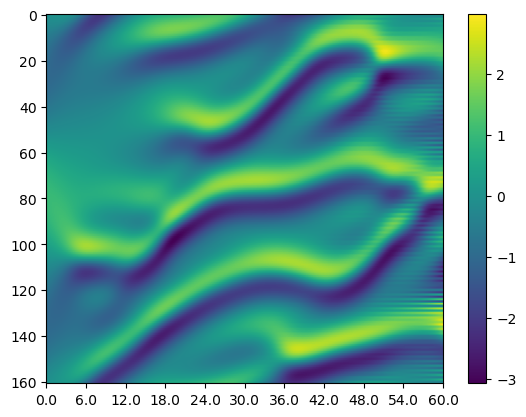

In [156]:
if idx_arr[0].shape[0] != 0:
    plt.imshow(all_data[0:idx_arr[0][0]-int(5/delta_t)].transpose(), aspect='auto')
else:
    plt.imshow(all_data.transpose(), aspect='auto')
numtsteps = int( (T+0.1*delta_t)//delta_t )
ticks = np.linspace(0, numtsteps, 1+10, dtype=np.int32 )
plt.xticks(ticks, ticks*T/numtsteps)
plt.colorbar()